# Analyze Solar Array Performance

In this notebook, we will use the [pvlib](https://pvlib-python.readthedocs.io/en/stable/) Python package to predict the output of the solar array on the roof of the highschool. We will then compare the output to historical data.

![](./solar_panels.jpg)

## Load Libraries

We'll get started by loading libraries and setting default plotting parameters.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# We also need to install the solar modeling package pvlib
# If running in Google Colab, you can install it by running the following command
# !pip install 'pvlib[optional]'
%pip install 'pvlib[optional]'

# The following code sets default font sizes and styles for the plots
# Modified from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=3)

Note: you may need to restart the kernel to use updated packages.


## Obtain and Visualize Meterological Data

The first step is to obtain meterological data for the years of interest. The National Renewable Energy Labratory (NREL) provides the dataset "USA Continental & Mexico - (5, 30, 60min / 2km / 2019-2022)" for free at https://nsrdb.nrel.gov/data-viewer for years 2018 to 2022.

We already downloaded the dataset for the location closest to the GPS coordinates of Lakeshore Highschool.

Let's get started by importing the data.



In [2]:
# These data files are all shared (viewable) in Google Drive
# Create a dictionary to store all of the unique FILE_IDs for Google Drive
data_file_ids = {}
data_file_ids[2022] = '1ZATFflB62KstcAAf66m6k-BNnw3vpm7U'
data_file_ids[2021] = '1GgbtcyCQy3OxNbX2WYFZhObYVVk5RA4F'
data_file_ids[2020] = '1EmAh-z59w0sl5yPLoogWuUHyzQGbvBx6'
data_file_ids[2019] = '1QdglH5gN6oPnXuUzCTG8UcTnWf_elFbX'
data_file_ids[2018] = '1XaAEfYpqFlU79YVYPboaFiJjq1lQXrah'

def download_data_file(file_id,type='met'):
    """
    Download data file from Google Drive
    """
    url = 'https://drive.google.com/uc?export=download&id='+file_id
    if type == 'met':
        return pd.read_csv(url, header=2)
    elif type == 'solar':
        temp = pd.read_csv(url)
        temp.set_index('date', inplace=True)
        temp.index = pd.to_datetime(temp.index)
        temp.columns = ['power']
        return temp
    else:
        raise ValueError('type must be "met" or "solar"')

data = download_data_file(data_file_ids[2022])
data.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,...,Pressure,Cloud Type,Solar Zenith Angle,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Fill Flag,Precipitable Water,Wind Direction
0,2022,1,1,0,0,0,0,4.1,0.16,4.0,...,981,7,158.38,0,0,0,0,0,1.2,353
1,2022,1,1,0,5,0,0,4.1,0.16,4.1,...,981,7,158.85,0,0,0,0,0,1.2,324
2,2022,1,1,0,10,0,0,4.1,0.16,4.1,...,982,8,159.29,0,0,0,0,0,1.2,294
3,2022,1,1,0,15,0,0,4.1,0.16,4.2,...,982,7,159.68,0,0,0,0,0,1.2,265
4,2022,1,1,0,20,0,0,4.1,0.16,4.2,...,982,8,160.02,0,0,0,0,0,1.2,235


Next, let's visualize some meterological data for the first week of the calendar year 2022.

In [3]:
hours_since_beginning_of_year = data.index*5/60

# 7 days * 24 hours per day * 20 5-minute intervals per hour
first_week = 7*24*20

We'll start with temperature.

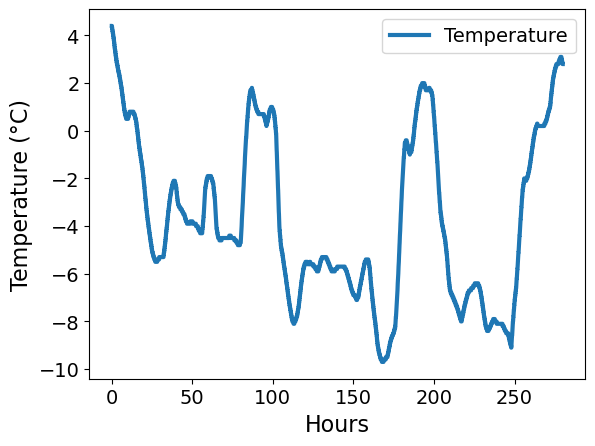

In [4]:


plt.plot(hours_since_beginning_of_year[:first_week],
         data['Temperature'].values[:first_week],
         label='Temperature')
plt.xlabel('Hours')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.show()

Next, we will plot **direct normal irrandiance (DNI)** and **direct horizontal irrandiance (DHI)**.

Solar irradiance is often reported as **direct** and **diffuse**. On cloudy days, there is a lot of diffuse irradiance but almost no direct irradiance because the clouds block the sun.

**Normal** means the amount of irradiance if the solar panel was pointed directly at the sun, whereas **horizonal** is for a solar panel that is flat on the ground. Notice the normal irradiance is always greater than the horizontal irradience.

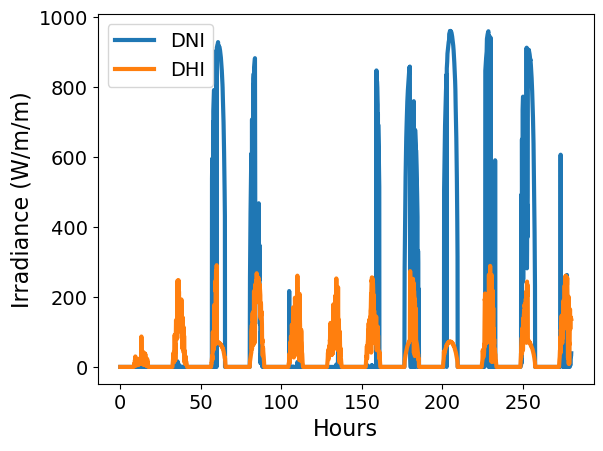

In [5]:
plt.plot(hours_since_beginning_of_year[:first_week],
         data['DNI'].values[:first_week],
         label='DNI')
plt.plot(hours_since_beginning_of_year[:first_week],
         data['DHI'].values[:first_week],
         label='DHI')
plt.xlabel('Hours')
plt.ylabel('Irradiance (W/m/m)')
plt.legend()

plt.show()

Now let's look at the data plotted for the entire year.

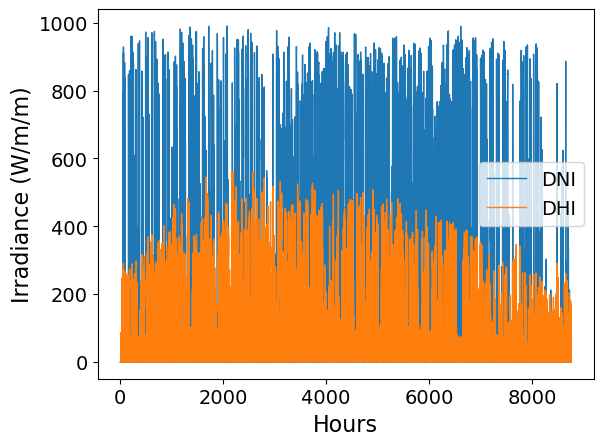

In [6]:
# Reset the line thickness for annual plots
plt.rc('lines', linewidth=1)

plt.plot(hours_since_beginning_of_year,
         data['DNI'],
         label='DNI')
plt.plot(hours_since_beginning_of_year,
         data['DHI'],
         label='DHI')
plt.xlabel('Hours')
plt.ylabel('Irradiance (W/m/m)')
plt.legend()

plt.show()

## Model Solar Panel Performance

Now that we have the weather data, we can model the solar panel performance.

We will start with this example: https://pvlib-python.readthedocs.io/en/stable/gallery/bifacial/plot_pvfactors_fixed_tilt.html

And possibly use this example to calculate only the monofacial performance: https://pvlib-python.readthedocs.io/en/stable/gallery/bifacial/plot_bifi_model_pvwatts.html

In [7]:
from pvlib import location
from pvlib.bifacial.pvfactors import pvfactors_timeseries

import warnings

# supressing shapely warnings that occur on import of pvfactors
warnings.filterwarnings(action='ignore', module='pvfactors')

In [8]:
times = pd.date_range('2022-01-01', # start at the beginning of the year
                      '2023-01-01', # end at the beginning of the next year
                      freq='5min', # every 5 minutes
                      tz='America/New_York', # select time zone
                      inclusive='left') # only include beginning of year
loc = location.Location(latitude=42.5226, longitude=-82.8809, tz=times.tz) # Lake Shore High School
sp = loc.get_solarposition(times)
# cs = loc.get_clearsky(times) # not needed as we will use weather data instead

# Height of the pv rows, measured at their center (m)
pvrow_height = 1 # default

# Width of the pv rows in the considered 2D plane (m)
pvrow_width = 4 # default

pitch = 10 # default

# Ground coverage ratio of the pv array
gcr = pvrow_width / pitch
# small gcr means less shading, I think (see link below)
# https://pvlib-python.readthedocs.io/en/stable/gallery/shading/plot_passias_diffuse_shading.html

axis_azimuth = 180 #
# albedo = 0.2 # not needed as we will use weather

In [9]:
irrad = pvfactors_timeseries(
    solar_azimuth=sp['azimuth'],
    solar_zenith=sp['apparent_zenith'],
    surface_azimuth=180,  # south-facing array
    surface_tilt=12.5, # degrees,
    axis_azimuth=90,  # 90 degrees off from surface_azimuth.  270 is ok too
    timestamps=times,
    dni=data['DNI'],
    dhi=data['DHI'],
    gcr=gcr,
    pvrow_height=pvrow_height,
    pvrow_width=pvrow_width,
    albedo=data['Surface Albedo'],
    n_pvrows=1,
    index_observed_pvrow=0
)

# turn into pandas DataFrame
irrad = pd.concat(irrad, axis=1)

# irrad[['total_inc_back', 'total_abs_back']].plot()
# plt.ylabel('Irradiance [W m$^{-2}$]')

# Show the first few rows of the results DataFrame
irrad.head()

,total_inc_front,total_inc_back,total_abs_front,total_abs_back
2022-01-01 00:00:00-05:00,0.0,0.0,0.0,0.0
2022-01-01 00:05:00-05:00,0.0,0.0,0.0,0.0
2022-01-01 00:10:00-05:00,0.0,0.0,0.0,0.0
2022-01-01 00:15:00-05:00,0.0,0.0,0.0,0.0
2022-01-01 00:20:00-05:00,0.0,0.0,0.0,0.0


Now let's plot the total absolute irradiance on the front of the panel.

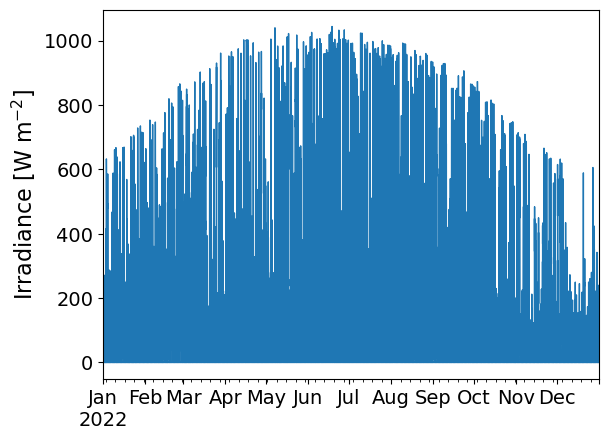

In [10]:
irrad['total_abs_front'].plot()
plt.ylabel('Irradiance [W m$^{-2}$]')
plt.show()

## Analyze Solar Data

We are now ready to analyze historical data from the solar panels on top of the highschool. We have already downloaded the data for years 2019 to 2023.

In [11]:
data_file_solar = {}
data_file_solar[2023] = '1_bzWjw6HiuSwa5zOrSbsbd5qLE837leX'
data_file_solar[2022] = '1cntIRQ6nIfVqwiJp-CxyYBMfh6SAmrzD'
data_file_solar[2021] = '1tlLJNLU2FMu-ZqqsRygFjIyQhPmxPAzy'
data_file_solar[2020] = '15ub5BE-MbktnFV5MGFh559-nmH1SoUBA'
data_file_solar[2019] = '1Hc49CskJfSKXjMGDZUgE-2302HDjnqwQ'

In [12]:
# Download the data files from Google Drive
solar_data = download_data_file(data_file_solar[2022], type='solar')
solar_data.head()

,power
date,
2022-01-01 00:00:00,NaN
2022-01-01 00:15:00,NaN
2022-01-01 00:30:00,NaN
2022-01-01 00:45:00,NaN
2022-01-01 01:00:00,NaN


You'll see the hours near midnight have *NaN*, which stands for *Not a Number*. This is because the solar panels are off and no data were recorded.

Next, let's plot the solar irradiance data for the year.

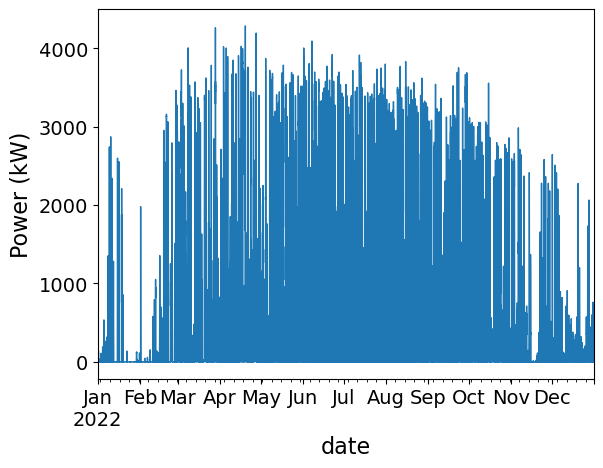

In [13]:
solar_data['power'].plot()
plt.ylabel('Power (kW)')
plt.show()


## Compare Historial Data and Model Predictions

Now, let's compare the historical data and model predictiopns on a single plot. This is called an *x-y-y plot* because there are two verical axes with different labels and units. The horizontal axis (time) is shared for both data sets.

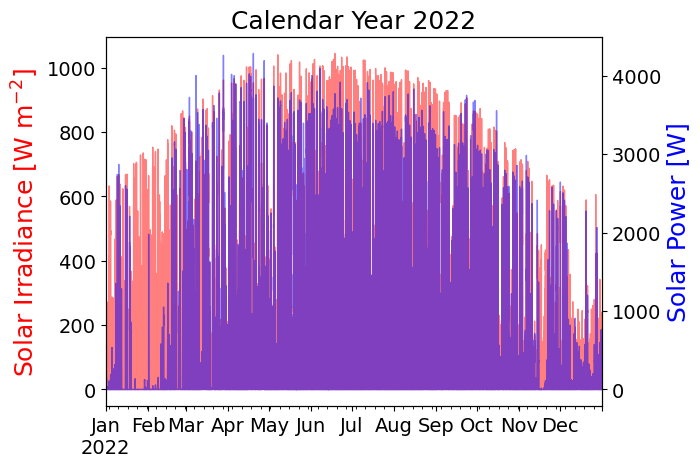

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
irrad['total_abs_front'].plot(ax=ax1,color='red',alpha=0.5)
solar_data['power'].plot(ax=ax2,color='blue',alpha=0.5)
plt.title('Calendar Year 2022',fontsize=18)
ax1.set_ylabel('Solar Irradiance [W m$^{-2}$]', color='red', fontsize=18)
ax2.set_ylabel('Solar Power [W]', color='blue', fontsize=18)
plt.show()

Our meterological data is available every 5 minutes, which means we have a model prediction from pvlib for every 5 minutes. Our historical solar panel data is only available every 15 minutes.

The code below averages the meterlogical data to be in 15 minute increments. Having a common time increment (every 15 minutes) will make it easier to compare the two datasets.

In [15]:
irrad_resample = irrad['total_abs_front'].resample('15min').mean()
irrad_resample.head()

2022-01-01 00:00:00-05:00    0.0
2022-01-01 00:15:00-05:00    0.0
2022-01-01 00:30:00-05:00    0.0
2022-01-01 00:45:00-05:00    0.0
2022-01-01 01:00:00-05:00    0.0
Freq: 15min, Name: total_abs_front, dtype: float64

Now let's remake the plot, but using the 15-minute incremements for the solar panel model predictions. The plots above and below look almost identifical. This makes sense because converting from 5-minute to 15-minute data should not matter too much when looking at trends over the entire year.

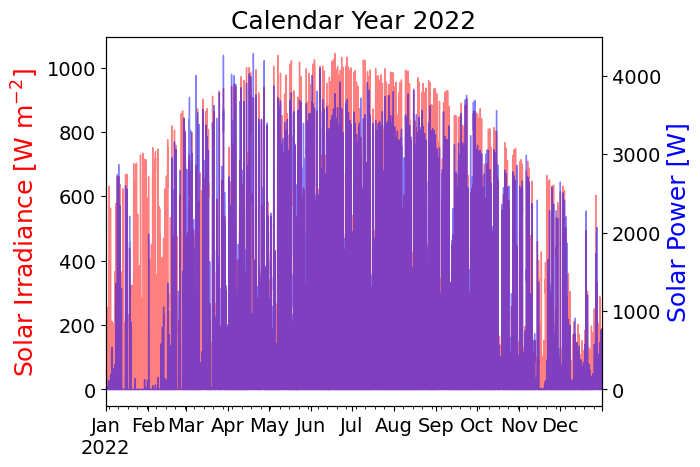

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
irrad_resample.plot(ax=ax1,color='red',alpha=0.5)
solar_data['power'].plot(ax=ax2,color='blue',alpha=0.5)
plt.title('Calendar Year 2022',fontsize=18)
ax1.set_ylabel('Solar Irradiance [W m$^{-2}$]', color='red', fontsize=18)
ax2.set_ylabel('Solar Power [W]', color='blue', fontsize=18)
plt.show()

Finally, let's make a scatter plot to compare the solar irradiance (as predicted by pvlib and the meterlogical data) versus the actual measured solar power.

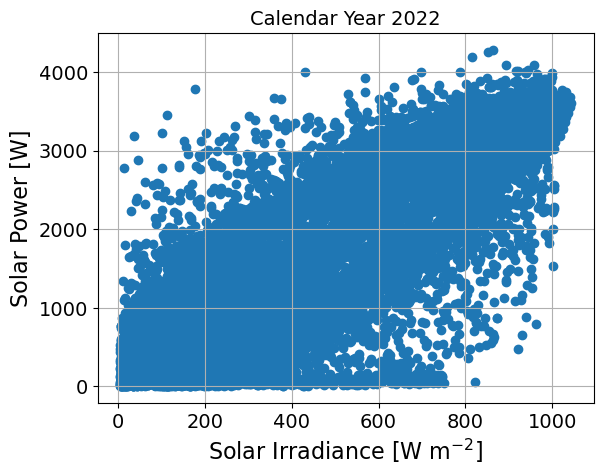

In [17]:
irrandiance = irrad_resample.to_numpy()
solar = solar_data['power'].to_numpy()

# Select times when the irradiance and solar power are above a certain threshold
min_irrandiance = 5 # W / m / m
min_solar_power = 5 # W
i = irrandiance > min_irrandiance
j = solar > min_solar_power
k = i & j


# Generate plot
plt.scatter(irrandiance[k], solar[k])
plt.xlabel('Solar Irradiance [W m$^{-2}$]')
plt.ylabel('Solar Power [W]')
plt.title('Calendar Year 2022')
plt.grid(True)
plt.show()

Next, let's perform linear regression.

In [18]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(irrandiance[k], solar[k])
print("slope = ",round(slope,3)," 1 / m / m")
print("intercept = ",round(intercept,2)," W")

slope =  3.016  1 / m / m
intercept =  192.91  W


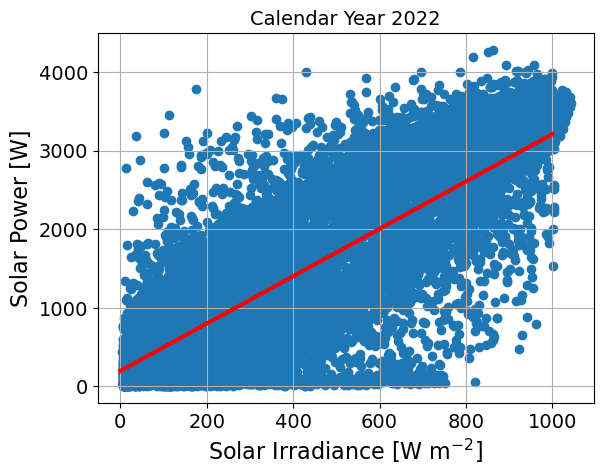

In [19]:
def myfunc(x):
  return slope * x + intercept

x_plot = np.linspace(0, 1000, 101)
y_plot = myfunc(x_plot)

plt.scatter(irrandiance[k], solar[k])
plt.plot(x_plot, y_plot, color='red', linewidth=3)
plt.xlabel('Solar Irradiance [W m$^{-2}$]')
plt.ylabel('Solar Power [W]')
plt.title('Calendar Year 2022')
plt.grid(True)
plt.show()

## Calendar Year 2019

Finally, we want to analyze one calendar year at a time. We will write a function in Python to help us do this!

In [20]:
def analyze_year(year=2019, min_irrandiance=10, min_solar_power=10):
    """ Analyze solar panel data for a given year. This function does the following:
    1. Downloads meterological data and solar panel data for the given year
    2. Simulates solar panels to calculate available solar irradiance
    3. Performs linear regression analysis.

    Any times where the irradiance is less than min_irrandiance or the 
    solar power is less than min_solar_power are excluded from the analysis.

    Arugments:
        year: int, the year to analyze
        min_irrandiance: float, the minimum irradiance to consider (W/m^2)
        min_solar_power: float, the minimum solar power to consider (W)

    """


    ## Download meterological data
    met_data = data = download_data_file(data_file_ids[year], type='met')
    print("Finished downloading met data")

    ## Configure solar panel simulation
    times = pd.date_range(str(year)+'-01-01', # start at the beginning of the year
                      str(year+1)+'-01-01', # end at the beginning of the next year
                      freq='5min', # every 5 minutes
                      tz='America/New_York', # select time zone
                      inclusive='left') # only include beginning of year
    loc = location.Location(latitude=42.5226, longitude=-82.8809, tz=times.tz) # Lake Shore High School
    sp = loc.get_solarposition(times)
    # cs = loc.get_clearsky(times) # not needed as we will use weather data instead

    # Height of the pv rows, measured at their center (m)
    pvrow_height = 1 # default

    # Width of the pv rows in the considered 2D plane (m)
    pvrow_width = 4 # default

    pitch = 10 # default

    # Ground coverage ratio of the pv array
    gcr = pvrow_width / pitch
    # small gcr means less shading, I think (see link below)
    # https://pvlib-python.readthedocs.io/en/stable/gallery/shading/plot_passias_diffuse_shading.html

    axis_azimuth = 180 #
    # albedo = 0.2 # not needed as we will use weather

    ## Simulate solar panels
    irrad = pvfactors_timeseries(
        solar_azimuth=sp['azimuth'],
        solar_zenith=sp['apparent_zenith'],
        surface_azimuth=180,  # south-facing array
        surface_tilt=12.5, # degrees,
        axis_azimuth=90,  # 90 degrees off from surface_azimuth.  270 is ok too
        timestamps=times,
        dni=data['DNI'],
        dhi=data['DHI'],
        gcr=gcr,
        pvrow_height=pvrow_height,
        pvrow_width=pvrow_width,
        albedo=data['Surface Albedo'],
        n_pvrows=1,
        index_observed_pvrow=0
    )
    print("Finished simulating solar cells")

    # turn into pandas DataFrame
    irrad = pd.concat(irrad, axis=1)

    # Convert to 15 minute intervals
    irrad_resample = irrad['total_abs_front'].resample('15min').mean()

    ## Download solar data
    solar_data = download_data_file(data_file_solar[year], type='solar')
    print("Finished downloading solar panel data")

    ## Plot data
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    irrad_resample.plot(ax=ax1,color='red',alpha=0.5)
    solar_data['power'].plot(ax=ax2,color='blue',alpha=0.5)
    plt.title('Calendar Year '+str(year),fontsize=18)
    ax1.set_ylabel('Solar Irradiance [W m$^{-2}$]', color='red', fontsize=18)
    ax2.set_ylabel('Solar Power [W]', color='blue', fontsize=18)
    plt.show()

    ## Perform regression
    irrandiance = irrad_resample.to_numpy()
    solar = solar_data['power'].to_numpy()
    i = irrandiance > min_irrandiance
    j = solar > min_solar_power

    k = i & j

    slope, intercept, r_value, p_value, std_err = linregress(irrandiance[k], solar[k])

    ## Plot data

    def myfunc(x):
        return slope * x + intercept

    x_plot = np.linspace(0, 1000, 101)
    y_plot = myfunc(x_plot)

    plt.scatter(irrandiance[k], solar[k])
    plt.plot(x_plot, y_plot, color='red', linewidth=3)
    plt.xlabel('Solar Irradiance [W m$^{-2}$]',fontsize=18)
    plt.ylabel('Solar Power [W]',fontsize=18)
    plt.title('Calendar Year '+str(year),fontsize=18)
    plt.grid(True)
    plt.show()
    print("slope = ",round(slope,3)," 1 / m / m")
    print("intercept = ",round(intercept,2)," W")
    print("r_value = ",round(r_value,3))
    #print("p_value = ",round(p_value,3))
    #print("std_err = ",round(std_err,3))


Finished downloading met data
Finished simulating solar cells
Finished downloading solar panel data


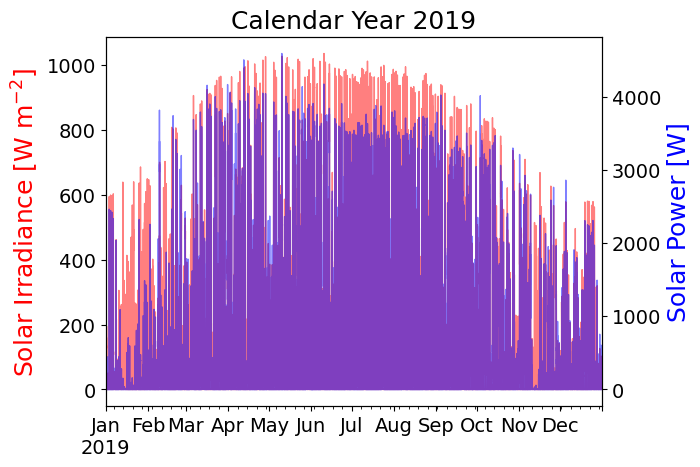

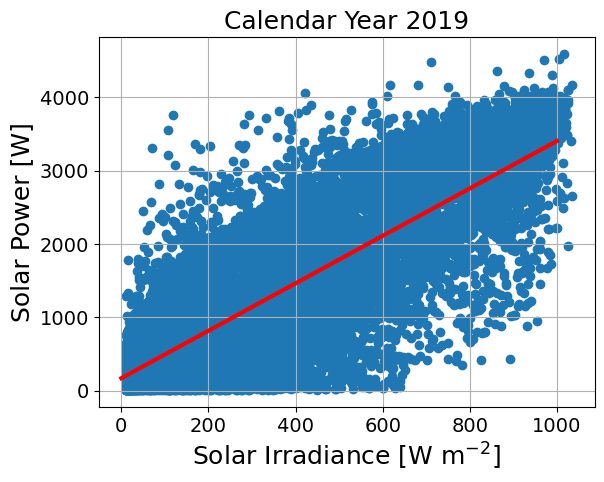

slope =  3.235  1 / m / m
intercept =  169.85  W
r_value =  0.822


In [21]:
analyze_year(2019)

## Calendar Year 2020



Finished downloading met data
Finished simulating solar cells
Finished downloading solar panel data


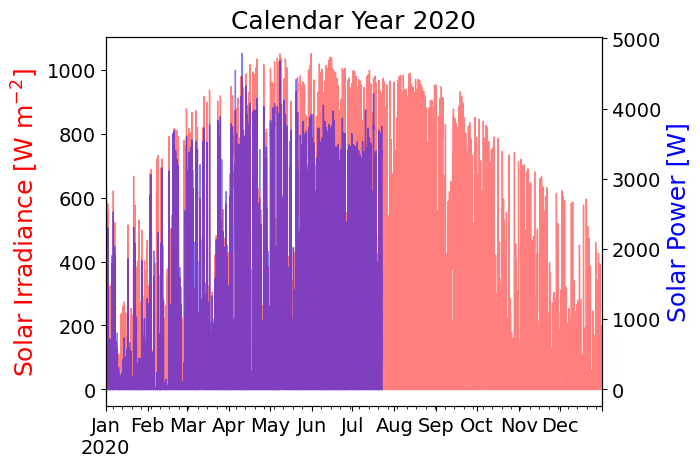

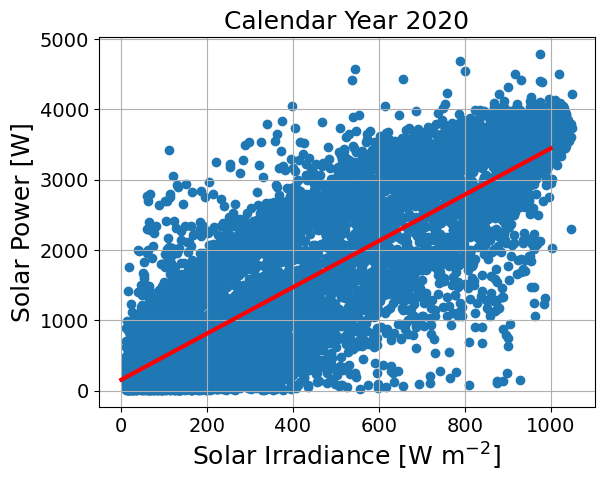

slope =  3.287  1 / m / m
intercept =  155.4  W
r_value =  0.837


In [22]:
analyze_year(2020)

## Calendar Year 2021

Finished downloading met data
Finished simulating solar cells
Finished downloading solar panel data


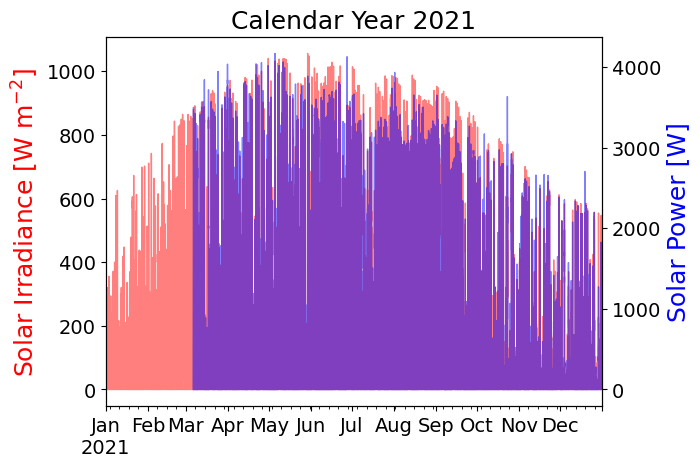

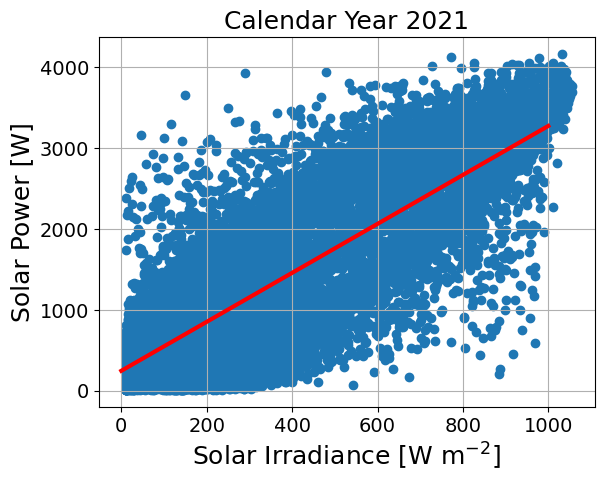

slope =  3.028  1 / m / m
intercept =  246.88  W
r_value =  0.823


In [23]:
analyze_year(2021)

## Calendar Year 2022

Finished downloading met data
Finished simulating solar cells
Finished downloading solar panel data


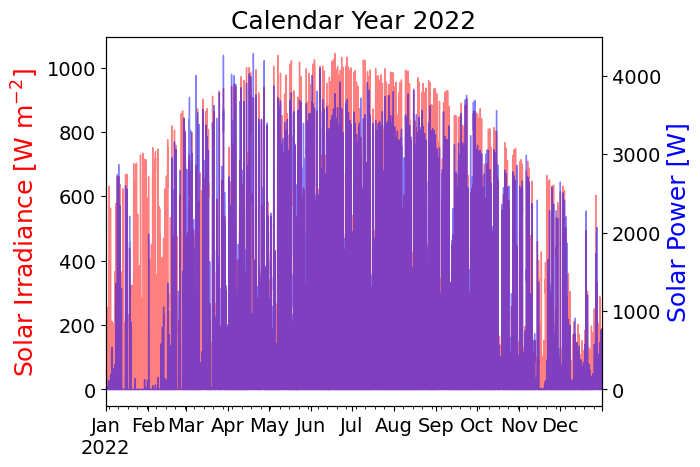

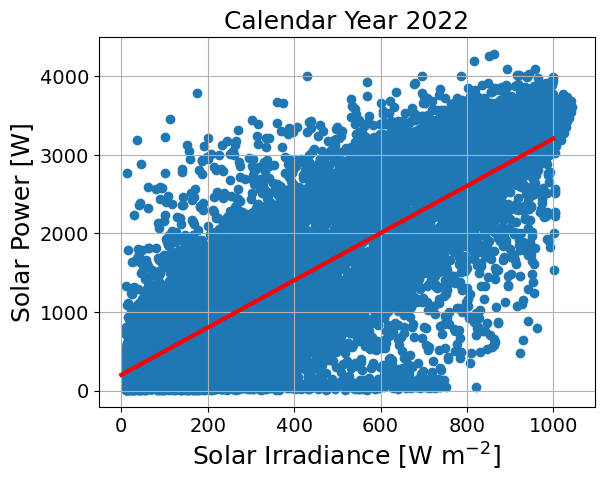

slope =  3.005  1 / m / m
intercept =  201.83  W
r_value =  0.803


In [25]:
analyze_year(2022)